# Machine translation

The goal of this TP is to build a machine translation model.
You will be comparing the performance of three different architectures:
* A Vanilla RNN (**Implementation provided!**)
* A GRU-RNN (done individually)
* A Transformer (The implementation, testing and experiments with an Encoder-Decoder - done individually, and a high level architecture and plan for a Decoder only model - done in groups of 3-4)

You are provided with the code to load and build the pytorch dataset, the implementation for the Vanilla RNN architecture
and the code for the training loop.
You "only" have to code the architectures (GRU-RNN, Full Transformer, Decoder-Only Transformer).
Of course, the use of built-in torch layers such as `nn.GRU` or `nn.Transformer`
is forbidden, as there would be no exercise otherwise.

The source sentences are in english and the target language is french.

This is also for you the occasion to see what a basic machine learning pipeline looks like.
Take a look at the given code, you might learn a lot!

Do not forget to **select the runtime type as GPU!**

**Sources**

* Dataset: [Tab-delimited Bilingual Sentence Pairs](http://www.manythings.org/anki/)

<!---
M. Cettolo, C. Girardi, and M. Federico. 2012. WIT3: Web Inventory of Transcribed and Translated Talks. In Proc. of EAMT, pp. 261-268, Trento, Italy. pdf, bib. [paper](https://aclanthology.org/2012.eamt-1.60.pdf). [website](https://wit3.fbk.eu/2016-01).
-->

* The code is inspired by this [pytorch tutorial](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html).

*This notebook is quite big, use the table of contents to easily navigate through it.*

# Imports and data initializations

We first download and parse the dataset. From the parsed sentences
we can build the vocabularies and the torch datasets.
The end goal of this section is to have an iterator
that can yield the pairs of translated datasets, and
where each sentences is made of a sequence of tokens.

## Imports

In [1]:
!python -m spacy download en > /dev/null
!python -m spacy download fr > /dev/null
!pip install torchinfo > /dev/null
!pip install einops > /dev/null
!pip install wandb > /dev/null

In [2]:
from itertools import takewhile
from collections import Counter, defaultdict

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torchtext.datasets import IWSLT2016

import einops
import wandb
from torchinfo import summary

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Our dataset
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip

df = pd.read_csv('fra.txt', sep='\t', names=['english', 'french', 'attribution'])
train = [
    (en, fr) for en, fr in zip(df['english'], df['french'])
]
train, valid = train_test_split(train, test_size=0.1, random_state=0)
print(len(train))

en_tokenizer, fr_tokenizer = get_tokenizer('spacy', language='en'), get_tokenizer('spacy', language='fr')

SPECIALS = ['<unk>', '<pad>', '<bos>', '<eos>']

--2024-04-05 23:07:10--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.57M  48.8MB/s    in 0.2s    

2024-04-05 23:07:11 (48.8 MB/s) - ‘fra-eng.zip’ saved [7943074/7943074]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 
209462


/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "fr" could not be loaded, trying "fr_core_news_sm" instead
  warnings.warn(


The tokenizers are objects that are able to divide a python string into a list of tokens (words, punctuations, special tokens...) as a list of strings.

The special tokens are used for a particular reasons:
* *\<unk\>*: Replace an unknown word in the vocabulary by this default token
* *\<pad\>*: Virtual token used to as padding token so a batch of sentences can have a unique length
* *\<bos\>*: Token indicating the beggining of a sentence in the target sequence
* *\<eos\>*: Token indicating the end of a sentence in the target sequence

## Datasets

Functions and classes to build the vocabularies and the torch datasets.
The vocabulary is an object able to transform a string token into the id (an int) of that token in the vocabulary.

In [4]:
class TranslationDataset(Dataset):
    def __init__(
            self,
            dataset: list,
            en_vocab: Vocab,
            fr_vocab: Vocab,
            en_tokenizer,
            fr_tokenizer,
        ):
        super().__init__()

        self.dataset = dataset
        self.en_vocab = en_vocab
        self.fr_vocab = fr_vocab
        self.en_tokenizer = en_tokenizer
        self.fr_tokenizer = fr_tokenizer

    def __len__(self):
        """Return the number of examples in the dataset.
        """
        return len(self.dataset)

    def __getitem__(self, index: int) -> tuple:
        """Return a sample.

        Args
        ----
            index: Index of the sample.

        Output
        ------
            en_tokens: English tokens of the sample, as a LongTensor.
            fr_tokens: French tokens of the sample, as a LongTensor.
        """
        # Get the strings
        en_sentence, fr_sentence = self.dataset[index]

        # To list of words
        # We also add the beggining-of-sentence and end-of-sentence tokens
        en_tokens = ['<bos>'] + self.en_tokenizer(en_sentence) + ['<eos>']
        fr_tokens = ['<bos>'] + self.fr_tokenizer(fr_sentence) + ['<eos>']

        # To list of tokens
        en_tokens = self.en_vocab(en_tokens)  # list[int]
        fr_tokens = self.fr_vocab(fr_tokens)

        return torch.LongTensor(en_tokens), torch.LongTensor(fr_tokens)


def yield_tokens(dataset, tokenizer, lang):
    """Tokenize the whole dataset and yield the tokens.
    """
    assert lang in ('en', 'fr')
    sentence_idx = 0 if lang == 'en' else 1

    for sentences in dataset:
        sentence = sentences[sentence_idx]
        tokens = tokenizer(sentence)
        yield tokens


def build_vocab(dataset: list, en_tokenizer, fr_tokenizer, min_freq: int):
    """Return two vocabularies, one for each language.
    """
    en_vocab = build_vocab_from_iterator(
        yield_tokens(dataset, en_tokenizer, 'en'),
        min_freq=min_freq,
        specials=SPECIALS,
    )
    en_vocab.set_default_index(en_vocab['<unk>'])  # Default token for unknown words

    fr_vocab = build_vocab_from_iterator(
        yield_tokens(dataset, fr_tokenizer, 'fr'),
        min_freq=min_freq,
        specials=SPECIALS,
    )
    fr_vocab.set_default_index(fr_vocab['<unk>'])

    return en_vocab, fr_vocab


def preprocess(
        dataset: list,
        en_tokenizer,
        fr_tokenizer,
        max_words: int,
    ) -> list:
    """Preprocess the dataset.
    Remove samples where at least one of the sentences are too long.
    Those samples takes too much memory.
    Also remove the pending '\n' at the end of sentences.
    """
    filtered = []

    for en_s, fr_s in dataset:
        if len(en_tokenizer(en_s)) >= max_words or len(fr_tokenizer(fr_s)) >= max_words:
            continue

        en_s = en_s.replace('\n', '')
        fr_s = fr_s.replace('\n', '')

        filtered.append((en_s, fr_s))

    return filtered


def build_datasets(
        max_sequence_length: int,
        min_token_freq: int,
        en_tokenizer,
        fr_tokenizer,
        train: list,
        val: list,
    ) -> tuple:
    """Build the training, validation and testing datasets.
    It takes care of the vocabulary creation.

    Args
    ----
        - max_sequence_length: Maximum number of tokens in each sequences.
            Having big sequences increases dramatically the VRAM taken during training.
        - min_token_freq: Minimum number of occurences each token must have
            to be saved in the vocabulary. Reducing this number increases
            the vocabularies's size.
        - en_tokenizer: Tokenizer for the english sentences.
        - fr_tokenizer: Tokenizer for the french sentences.
        - train and val: List containing the pairs (english, french) sentences.


    Output
    ------
        - (train_dataset, val_dataset): Tuple of the two TranslationDataset objects.
    """
    datasets = [
        preprocess(samples, en_tokenizer, fr_tokenizer, max_sequence_length)
        for samples in [train, val]
    ]

    en_vocab, fr_vocab = build_vocab(datasets[0], en_tokenizer, fr_tokenizer, min_token_freq)

    datasets = [
        TranslationDataset(samples, en_vocab, fr_vocab, en_tokenizer, fr_tokenizer)
        for samples in datasets
    ]

    return datasets


In [5]:
def generate_batch(data_batch: list, src_pad_idx: int, tgt_pad_idx: int) -> tuple:
    """Add padding to the given batch so that all
    the samples are of the same size.

    Args
    ----
        data_batch: List of samples.
            Each sample is a tuple of LongTensors of varying size.
        src_pad_idx: Source padding index value.
        tgt_pad_idx: Target padding index value.

    Output
    ------
        en_batch: Batch of tokens for the padded english sentences.
            Shape of [batch_size, max_en_len].
        fr_batch: Batch of tokens for the padded french sentences.
            Shape of [batch_size, max_fr_len].
    """
    en_batch, fr_batch = [], []
    for en_tokens, fr_tokens in data_batch:
        en_batch.append(en_tokens)
        fr_batch.append(fr_tokens)

    en_batch = pad_sequence(en_batch, padding_value=src_pad_idx, batch_first=True)
    fr_batch = pad_sequence(fr_batch, padding_value=tgt_pad_idx, batch_first=True)
    return en_batch, fr_batch

# Models architecture
This is where you have to code the architectures.

In a machine translation task, the model takes as input the whole
source sentence along with the current known tokens of the target,
and predict the next token in the target sequence.
This means that the target tokens are predicted in an autoregressive
manner, starting from the first token (right after the *\<bos\>* token) and producing tokens one by one until the last *\<eos\>* token.

Formally, we define $s = [s_1, ..., s_{N_s}]$ as the source sequence made of $N_s$ tokens.
We also define $t^i = [t_1, ..., t_i]$ as the target sequence at the beginning of the step $i$.

The output of the model parameterized by $\theta$ is:

$$
T_{i+1} = p(t_{i+1} | s, t^i ; \theta )
$$

Where $T_{i+1}$ is the distribution of the next token $t_{i+1}$.

The loss is simply a *cross entropy loss* over the whole steps, where each class is a token of the vocabulary.

![RNN schema for machinea translation](https://www.simplilearn.com/ice9/free_resources_article_thumb/machine-translation-model-with-encoder-decoder-rnn.jpg)

Note that in this image the english sentence is provided in reverse.

---

In pytorch, there is no dinstinction between an intermediate layer or a whole model having multiple layers in itself.
Every layers or models inherit from the `torch.nn.Module`.
This module needs to define the `__init__` method where you instanciate the layers,
and the `forward` method where you decide how the inputs and the layers of the module interact between them.
Thanks to the autograd computations of pytorch, you do not have
to implement any backward method!

A really important advice is to **always look at
the shape of your input and your output.**
From that, you can often guess how the layers should interact
with the inputs to produce the right output.
You can also easily detect if there's something wrong going on.

You are more than advised to use the `einops` library and the `torch.einsum` function. This will require less operations than 'classical' code, but note that it's a bit trickier to use.
This is a way of describing tensors manipulation with strings, bypassing the multiple tensor methods executed in the background.
You can find a nice presentation of `einops` [here](https://einops.rocks/1-einops-basics/).
A paper has just been released about einops [here](https://paperswithcode.com/paper/einops-clear-and-reliable-tensor).

**A great tutorial on pytorch can be found [here](https://stanford.edu/class/cs224n/materials/CS224N_PyTorch_Tutorial.html).**
Spending 3 hours on this tutorial is *no* waste of time.

## RNN models

### RNN
Here, the implementation of the RNN is provided as an example. Study this code and use it as an example for the GRU implementation, if needed.

The `RNNCell` layer produce one hidden state vector for each sentence in the batch
(useful for the output of the encoder), and also produce one embedding for each
token in each sentence (useful for the output of the decoder).

The `RNN` module is composed of a stack of `RNNCell`. Each token embeddings
coming out from a previous `RNNCell` is used as an input for the next `RNNCell` layer.

**Be careful !** Our `RNNCell` implementation is not exactly the same thing as
the PyTorch's `nn.RNNCell`. PyTorch implements only the operations for one token
(so you would need to loop through each tokens inside the `RNN` instead).

The same thing apply for the `GRU` and `GRUCell`.


In [6]:
class RNNCell(nn.Module):
    """A single RNN layer.

    Parameters
    ----------
        input_size: Size of each input token.
        hidden_size: Size of each RNN hidden state.
        dropout: Dropout rate.

    Important note: This layer does not exactly the same thing as nn.RNNCell does.
    PyTorch implementation is only doing one simple pass over one token for each batch.
    This implementation is taking the whole sequence of each batch and provide the
    final hidden state along with the embeddings of each token in each sequence.
    """
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            dropout: float,
        ):
        super().__init__()

        self.hidden_size = hidden_size

        # See pytorch definition: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        self.Wih = nn.Linear(input_size, hidden_size, device=DEVICE)
        self.Whh = nn.Linear(hidden_size, hidden_size, device=DEVICE)
        self.dropout = nn.Dropout(p=dropout)
        self.act = nn.Tanh()

    def forward(self, x: torch.FloatTensor, h: torch.FloatTensor) -> tuple:
        """Go through all the sequence in x, iteratively updating
        the hidden state h.

        Args
        ----
            x: Input sequence.
                Shape of [batch_size, seq_len, input_size].
            h: Initial hidden state.
                Shape of [batch_size, hidden_size].

        Output
        ------
            y: Token embeddings.
                Shape of [batch_size, seq_len, hidden_size].
            h: Last hidden state.
                Shape of [batch_size, hidden_size].
        """
        batch_size, seq_len, input_size = x.shape
        y = torch.zeros([batch_size, seq_len, self.hidden_size], device=DEVICE)

        for t in range(seq_len):
          input = x[:, t, :]
          w_input = self.Wih(input)
          w_hidden = self.Whh(h)
          h = self.act(w_input + w_hidden)
          y[:, t, :] = self.dropout(h)

        return y, h


class RNN(nn.Module):
    """Implementation of an RNN based
    on https://pytorch.org/docs/stable/generated/torch.nn.RNN.html.

    Parameters
    ----------
        input_size: Size of each input token.
        hidden_size: Size of each RNN hidden state.
        num_layers: Number of layers (RNNCell or GRUCell).
        dropout: Dropout rate.
        model_type: Either 'RNN' or 'GRU', to select which model we want.
            This parameter can be removed if you decide to use the module `GRU`.
            Indeed, `GRU` should have exactly the same code as this module,
            but with `GRUCell` instead of `RNNCell`. We let the freedom for you
            to decide at which level you want to specialise the modules (either
            in `TranslationRNN` by creating a `GRU` or a `RNN`, or in `RNN`
            by creating a `GRUCell` or a `RNNCell`).
    """
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            num_layers: int,
            dropout: float,
            model_type: str,
        ):
        super().__init__()

        self.hidden_size = hidden_size
        model_class = RNNCell if model_type == 'RNN' else GRUCell

        self.layers = nn.ModuleList()
        self.layers.append(model_class(input_size, hidden_size, dropout))
        for i in range(1, num_layers):
          self.layers.append(model_class(hidden_size, hidden_size, dropout))

    def forward(self, x: torch.FloatTensor, h: torch.FloatTensor=None) -> tuple:
        """Pass the input sequence through all the RNN cells.
        Returns the output and the final hidden state of each RNN layer

        Args
        ----
            x: Input sequence.
                Shape of [batch_size, seq_len, input_size].
            h: Hidden state for each RNN layer.
                Can be None, in which case an initial hidden state is created.
                Shape of [batch_size, n_layers, hidden_size].

        Output
        ------
            y: Output embeddings for each token after the RNN layers.
                Shape of [batch_size, seq_len, hidden_size].
            h: Final hidden state.
                Shape of [batch_size, n_layers, hidden_size].
        """
        input = x
        h = torch.zeros([x.shape[0], len(self.layers), self.hidden_size], device=x.device) if h is None else h
        final_h = torch.zeros_like(h, device=x.device)
        for l in range(len(self.layers)):
          input, h_out = self.layers[l](input, h[:, l, :])
          final_h[:, l, :] = h_out

        return input, final_h

### GRU
Here you have to implement a GRU-RNN. This architecture is close to the Vanilla RNN but perform different operations. Look up the pytorch documentation to figure out the differences.

In [7]:
class GRU(nn.Module):
    """Implementation of a GRU based on https://pytorch.org/docs/stable/generated/torch.nn.GRU.html.

    Parameters
    ----------
        input_size: Size of each input token.
        hidden_size: Size of each RNN hidden state.
        num_layers: Number of layers.
        dropout: Dropout rate.
    """
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            num_layers: int,
            dropout: float,
        ):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # Cellules du RNN
        cells = [GRUCell(input_size, hidden_size, dropout)]
        for i in range(1,num_layers) :
          cells.append(GRUCell(hidden_size, hidden_size, dropout))
        self.cells = nn.ModuleList(cells)

    def forward(self, x: torch.FloatTensor, h: torch.FloatTensor=None) -> tuple:
        """
        Args
        ----
            x: Input sequence
                Shape of [batch_size, seq_len, input_size].
            h: Initial hidden state for each layer.
                If 'None', then an initial hidden state (a zero filled tensor)
                is created.
                Shape of [batch_size, n_layers, hidden_size].

        Output
        ------
            output:
                Shape of [batch_size, seq_len, hidden_size].
            h_n: Final hidden state.
                Shape of [batch_size, n_layers, hidden size].
        """
        # TODO
        batch_size, seq_len, input_size = x.shape

        h_out = torch.zeros(batch_size, self.num_layers, self.hidden_size) if h is None else h

        for l in range(self.num_layers):
            x, h_out[:, l, :] = self.cells[l](x, h_out[:, l, :])
        y= x

        return y, h_out


class GRUCell(nn.Module):
    """A single GRU layer.

    Parameters
    ----------
        input_size: Size of each input token.
        hidden_size: Size of each RNN hidden state.
        dropout: Dropout rate.
    """
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            dropout: float,
        ):
        super().__init__()
        # TODO
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        # entrée vers cachée
        self.Wir = nn.Linear(input_size, hidden_size, device=DEVICE)
        self.Wiz = nn.Linear(input_size, hidden_size, device=DEVICE)
        self.Win = nn.Linear(input_size, hidden_size, device=DEVICE)
        # cachée vers cachée
        self.Whr = nn.Linear(hidden_size, hidden_size, device=DEVICE)
        self.Whz = nn.Linear(hidden_size, hidden_size, device=DEVICE)
        self.Whn = nn.Linear(hidden_size, hidden_size, device=DEVICE)


    def forward(self, x: torch.FloatTensor, h: torch.FloatTensor) -> tuple:
        """
        Args
        ----
            x: Input sequence.
                Shape of [batch_size, seq_len, input_size].
            h: Initial hidden state.
                Shape of [batch_size, hidden_size].

        Output
        ------
            y: Token embeddings.
                Shape of [batch_size, seq_len, hidden_size].
            h: Last hidden state.
                Shape of [batch_size, hidden_size].
        """
        # TODO
        batch_size, seq_len, input_size = x.shape
        y = torch.zeros([batch_size, seq_len, self.hidden_size], device=DEVICE)
        tanh = nn.Tanh()
        sigmoid = nn.Sigmoid()
        dropout = nn.Dropout(p=self.dropout)
        x = x.to(DEVICE)
        h = h.to(DEVICE)

        h_t = h
        for t in range(seq_len):
            x_t = x[:, t, :]
            r_t = sigmoid(self.Wir(x_t) + self.Whr(h_t))
            z_t = sigmoid(self.Wiz(x_t) + self.Whz(h_t))
            n_t = tanh(self.Win(x_t) + r_t * self.Whn(h_t))
            h_t = (1 - z_t) * n_t + z_t * h_t
            y[:, t, :] = dropout(h_t)
        return y, h_t

### Translation RNN

This module instanciates a vanilla RNN or a GRU-RNN and performs the translation task. This code des the following:
* Encodes the source and target sequence
* Passes the final hidden state of the encoder to the decoder (one for each layer)
* Decodes the hidden state into the target sequence

We use teacher forcing for training, meaning that when the next token is predicted, that prediction is based on the previous true target tokens.

In [8]:
class TranslationRNN(nn.Module):
    """Basic RNN encoder and decoder for a translation task.
    It can run as a vanilla RNN or a GRU-RNN.

    Parameters
    ----------
        n_tokens_src: Number of tokens in the source vocabulary.
        n_tokens_tgt: Number of tokens in the target vocabulary.
        dim_embedding: Dimension size of the word embeddings (for both language).
        dim_hidden: Dimension size of the hidden layers in the RNNs
            (for both the encoder and the decoder).
        n_layers: Number of layers in the RNNs.
        dropout: Dropout rate.
        src_pad_idx: Source padding index value.
        tgt_pad_idx: Target padding index value.
        model_type: Either 'RNN' or 'GRU', to select which model we want.
    """

    def __init__(
            self,
            n_tokens_src: int,
            n_tokens_tgt: int,
            dim_embedding: int,
            dim_hidden: int,
            n_layers: int,
            dropout: float,
            src_pad_idx: int,
            tgt_pad_idx: int,
            model_type: str,
        ):
        super().__init__()
        # TODO
        self.n_tokens_src = n_tokens_src
        self.n_tokens_tgt = n_tokens_tgt
        self.dim_embedding = dim_embedding
        self.dim_hidden = dim_hidden
        self.n_layers = n_layers
        self.dropout = dropout
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx
        self.model_type = model_type

        # Embeddings
        self.src_embeddings = nn.Embedding(n_tokens_src, dim_embedding, src_pad_idx)
        self.tgt_embeddings = nn.Embedding(n_tokens_tgt, dim_embedding, tgt_pad_idx)

        if model_type == 'RNN':
            self.encoder = RNN(dim_embedding, dim_hidden, n_layers, dropout, model_type)
            self.decoder = RNN(dim_embedding, dim_hidden, n_layers, dropout, model_type)
        else:
            self.encoder = GRU(dim_embedding, dim_hidden, n_layers, dropout)
            self.decoder = GRU(dim_embedding, dim_hidden, n_layers, dropout)

        # Conversion des embeddings en tokens
        self.out_layer = nn.Linear(dim_hidden, n_tokens_tgt)


    def forward(
        self,
        source: torch.LongTensor,
        target: torch.LongTensor
    ) -> torch.FloatTensor:
        """Predict the target tokens logits based on the source tokens.

        Args
        ----
            source: Batch of source sentences.
                Shape of [batch_size, src_seq_len].
            target: Batch of target sentences.
                Shape of [batch_size, tgt_seq_len].

        Output
        ------
            y: Distributions over the next token for all tokens in each sentences.
                Those need to be the logits only, do not apply a softmax because
                it will be done in the loss computation for numerical stability.
                See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more informations.
                Shape of [batch_size, tgt_seq_len, n_tokens_tgt].
        """

        embedded_source = self.src_embeddings(source)
        embedded_source = embedded_source.to(DEVICE)
        embedded_target = self.tgt_embeddings(target)
        embedded_target = embedded_target.to(DEVICE)

        # Encoder
        _, hidden = self.encoder(embedded_source)

        # Decoder
        y, _ = self.decoder(embedded_target, hidden)

        # Output layer
        y = self.out_layer(y)

        return y


## Transformer models
Here you have to code the Full Transformer and Decoder-Only Transformer architectures.
It is divided in three parts:
* Attention layers (done individually)
* Encoder and decoder layers (done individually)
* Full Transformer: gather the encoder and decoder layers (done individually)

The Transformer (or "Full Transformer") is presented in the paper: [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf). The [illustrated transformer](https://jalammar.github.io/illustrated-transformer/) blog can help you
understanding how the architecture works.
Once this is done, you can use [the annontated transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) to have an idea of how to code this architecture.
We encourage you to use `torch.einsum` and the `einops` library as much as you can. It will make your code simpler.

---
**Implementation order**

To help you with the implementation, we advise you following this order:
* Implement `TranslationTransformer` and use `nn.Transformer` instead of `Transformer`
* Implement `Transformer` and use `nn.TransformerDecoder` and `nn.TransformerEnocder`
* Implement the `TransformerDecoder` and `TransformerEncoder` and use `nn.MultiHeadAttention`
* Implement `MultiHeadAttention`

Do not forget to add `batch_first=True` when necessary in the `nn` modules.

### Positional Encoding


In [9]:
class PositionalEncoding(nn.Module):
    """
    This PE module comes from:
    Pytorch. (2021). LANGUAGE MODELING WITH NN.TRANSFORMER AND TORCHTEXT. https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """
    def __init__(self, d_model: int, dropout: float, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(max_len).unsqueeze(1).to(DEVICE)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)).to(DEVICE)
        pe = torch.zeros(max_len, 1, d_model).to(DEVICE)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = rearrange(x, "b s e -> s b e")
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        x = rearrange(x, "s b e -> b s e")
        return self.dropout(x)

### Attention layers
We use a `MultiHeadAttention` module, that is able to perform self-attention aswell as cross-attention (depending on what you give as queries, keys and values).

**Attention**


It takes the multiheaded queries, keys and values as input.
It computes the attention between the queries and the keys and return the attended values.

The implementation of this function can greatly be improved with *einsums*.

**MultiheadAttention**

Computes the multihead queries, keys and values and feed them to the `attention` function.
You also need to merge the key padding mask and the attention mask into one mask.

The implementation of this module can greatly be improved with *einops.rearrange*.

In [10]:
#V3
from einops.layers.torch import Rearrange


def attention(
        q: torch.FloatTensor,
        k: torch.FloatTensor,
        v: torch.FloatTensor,
        mask: torch.BoolTensor=None,
        dropout: nn.Dropout=None,
    ) -> tuple:
    """Computes multihead scaled dot-product attention from the
    projected queries, keys and values.

    Args
    ----
        q: Batch of queries.
            Shape of [batch_size, seq_len_1, n_heads, dim_model].
        k: Batch of keys.
            Shape of [batch_size, seq_len_2, n_heads, dim_model].
        v: Batch of values.
            Shape of [batch_size, seq_len_2, n_heads, dim_model].
        mask: Prevent tokens to attend to some other tokens (for padding or autoregressive attention).
            Attention is prevented where the mask is `True`.
            Shape of [batch_size, n_heads, seq_len_1, seq_len_2],
            or broadcastable to that shape.
        dropout: Dropout layer to use.

    Output
    ------
        y: Multihead scaled dot-attention between the queries, keys and values.
            Shape of [batch_size, seq_len_1, n_heads, dim_model].
        attn: Computed attention between the keys and the queries.
            Shape of [batch_size, n_heads, seq_len_1, seq_len_2].
    """
    # TODO

    # Calcul de l'attention
    attn = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(q.size(-1))

    # Application du masque
    if mask is not None:
        attn = attn.masked_fill(mask, -np.inf)

    attn = torch.nn.functional.softmax(attn, dim=-1)

    if dropout is not None:
        attn = dropout(attn)

    y = torch.matmul(attn, v)

    return y, attn


class MultiheadAttention(nn.Module):
    """Multihead attention module.
    Can be used as a self-attention and cross-attention layer.
    The queries, keys and values are projected into multiple heads
    before computing the attention between those tensors.

    Parameters
    ----------
        dim: Dimension of the input tokens.
        n_heads: Number of heads. `dim` must be divisible by `n_heads`.
        dropout: Dropout rate.
    """
    def __init__(
            self,
            dim: int,
            n_heads: int,
            dropout: float,
        ):
        super().__init__()

        assert dim % n_heads == 0

        # TODO

        self.dim = dim // n_heads
        self.n_heads = n_heads
        self.linear_q = nn.Linear(dim, dim)
        self.linear_k = nn.Linear(dim, dim)
        self.linear_v = nn.Linear(dim, dim)
        self.linear_o = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.attn = None

    def forward(
            self,
            q: torch.FloatTensor,
            k: torch.FloatTensor,
            v: torch.FloatTensor,
            key_padding_mask: torch.BoolTensor = None,
            attn_mask: torch.BoolTensor = None,
        ) -> torch.FloatTensor:
        """Computes the scaled multi-head attention form the input queries,
        keys and values.

        Project those queries, keys and values before feeding them
        to the `attention` function.

        The masks are boolean masks. Tokens are prevented to attends to
        positions where the mask is `True`.

        Args
        ----
            q: Batch of queries.
                Shape of [batch_size, seq_len_1, dim_model].
            k: Batch of keys.
                Shape of [batch_size, seq_len_2, dim_model].
            v: Batch of values.
                Shape of [batch_size, seq_len_2, dim_model].
            key_padding_mask: Prevent attending to padding tokens.
                Shape of [batch_size, seq_len_2].
            attn_mask: Prevent attending to subsequent tokens.
                Shape of [seq_len_1, seq_len_2].

        Output
        ------
            y: Computed multihead attention.
                Shape of [batch_size, seq_len_1, dim_model].
        """
        # TODO

        batch_size_query, seq_len_query, dim_query = q.shape
        batch_size_key, seq_len_key, dim_key = k.shape

        key_padding_mask = key_padding_mask.unsqueeze(1).unsqueeze(2)
        key_padding_mask = key_padding_mask.repeat(1, self.n_heads, seq_len_query, 1)

        # Combinaison des masques
        mask = key_padding_mask
        if attn_mask is not None:
            attn_mask = attn_mask.unsqueeze(0).unsqueeze(0)
            attn_mask = attn_mask.repeat(batch_size_query, self.n_heads, 1, 1)
            attn_mask = attn_mask.to(DEVICE)
            mask = mask.bool() | attn_mask.bool()

        # Calcul des projections
        q = self.linear_q(q)
        k = self.linear_k(k)
        v = self.linear_v(v)

        q = q.view(batch_size_query, seq_len_query, self.n_heads, self.dim).transpose(1, 2)
        k = k.view(batch_size_key, seq_len_key, self.n_heads, self.dim).transpose(1, 2)
        v = v.view(batch_size_key, seq_len_key, self.n_heads, self.dim).transpose(1, 2)

        # Calcul de l'attention
        y, self.attn = attention(q, k, v, mask, self.dropout)

        # Calcul de l'output final
        y = y.transpose(1, 2).contiguous().view(batch_size_query, -1, self.n_heads * self.dim)

        y = self.linear_o(y)

        return y




### Encoder and decoder layers

**TranformerEncoder**

Apply self-attention layers onto the source tokens.
It only needs the source key padding mask.


**TranformerDecoder**

Apply masked self-attention layers to the target tokens and cross-attention
layers between the source and the target tokens.
It needs the source and target key padding masks, and the target attention mask.

In [11]:
class TransformerDecoderLayer(nn.Module):
    """Single decoder layer.

    Parameters
    ----------
        d_model: The dimension of decoders inputs/outputs.
        dim_feedforward: Hidden dimension of the feedforward networks.
        nheads: Number of heads for each multi-head attention.
        dropout: Dropout rate.
    """

    def __init__(
            self,
            d_model: int,
            d_ff: int,
            nhead: int,
            dropout: float
        ):
        super().__init__()

        # TODO
        # Masked Multihead attention
        self.masked_multihead_attn = MultiheadAttention(d_model, nhead, dropout)
        # Multihead attention pour combiner la source et la sortie du masked multihead attention
        self.multihead_attn = MultiheadAttention(d_model, nhead, dropout)

        self.feedforward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

        self.dropout = nn.Dropout(dropout)

        # pour normaliser les sorties
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(
            self,
            src: torch.FloatTensor,
            tgt: torch.FloatTensor,
            tgt_mask_attn: torch.BoolTensor,
            src_key_padding_mask: torch.BoolTensor,
            tgt_key_padding_mask: torch.BoolTensor,
        ) -> torch.FloatTensor:
        """Decode the next target tokens based on the previous tokens.

        Args
        ----
            src: Batch of source sentences.
                Shape of [batch_size, src_seq_len, dim_model].
            tgt: Batch of target sentences.
                Shape of [batch_size, tgt_seq_len, dim_model].
            tgt_mask_attn: Mask to prevent attention to subsequent tokens.
                Shape of [tgt_seq_len, tgt_seq_len].
            src_key_padding_mask: Mask to prevent attention to padding in src sequence.
                Shape of [batch_size, src_seq_len].
            tgt_key_padding_mask: Mask to prevent attention to padding in tgt sequence.
                Shape of [batch_size, tgt_seq_len].

        Output
        ------
            y:  Batch of sequence of embeddings representing the predicted target tokens
                Shape of [batch_size, tgt_seq_len, dim_model].
        """
        # TODO

        # Masked Multihead attention
        tgt_multihead_attn1 = self.masked_multihead_attn(tgt, tgt, tgt, tgt_key_padding_mask, tgt_mask_attn)

        # Addition et normalisation
        tgt1 = tgt + self.dropout(tgt_multihead_attn1)
        tgt1 = self.norm1(tgt)

        # Multihead attention
        tgt_multihead_attn2 = self.multihead_attn(tgt1, src, src, src_key_padding_mask)

        # Addition et normalisation
        tgt2 = tgt1 + self.dropout(tgt_multihead_attn2)
        tgt2 = self.norm2(tgt2)

        # Feedforward
        tgt_ff = self.feedforward(tgt2)

        # Addition et normalisation
        y = tgt2 + self.dropout(tgt_ff)
        y = self.norm3(y)

        return y




class TransformerDecoder(nn.Module):
    """Implementation of the transformer decoder stack.

    Parameters
    ----------
        d_model: The dimension of decoders inputs/outputs.
        dim_feedforward: Hidden dimension of the feedforward networks.
        num_decoder_layers: Number of stacked decoders.
        nheads: Number of heads for each multi-head attention.
        dropout: Dropout rate.
    """

    def __init__(
            self,
            d_model: int,
            d_ff: int,
            num_decoder_layer:int ,
            nhead: int,
            dropout: float
        ):
        super().__init__()

        # TODO
        self.layers = nn.ModuleList([TransformerDecoderLayer(d_model, d_ff, nhead, dropout) for i in range(num_decoder_layer)])


    def forward(
            self,
            src: torch.FloatTensor,
            tgt: torch.FloatTensor,
            tgt_mask_attn: torch.BoolTensor,
            src_key_padding_mask: torch.BoolTensor,
            tgt_key_padding_mask: torch.BoolTensor,
        ) -> torch.FloatTensor:
        """Decodes the source sequence by sequentially passing.
        the encoded source sequence and the target sequence through the decoder stack.

        Args
        ----
            src: Batch of encoded source sentences.
                Shape of [batch_size, src_seq_len, dim_model].
            tgt: Batch of taget sentences.
                Shape of [batch_size, tgt_seq_len, dim_model].
            tgt_mask_attn: Mask to prevent attention to subsequent tokens.
                Shape of [tgt_seq_len, tgt_seq_len].
            src_key_padding_mask: Mask to prevent attention to padding in src sequence.
                Shape of [batch_size, src_seq_len].
            tgt_key_padding_mask: Mask to prevent attention to padding in tgt sequence.
                Shape of [batch_size, tgt_seq_len].

        Output
        ------
            y:  Batch of sequence of embeddings representing the predicted target tokens
                Shape of [batch_size, tgt_seq_len, dim_model].
        """
        # TODO
        y = tgt
        for layer in self.layers:
            y = layer(src, y, tgt_mask_attn, src_key_padding_mask, tgt_key_padding_mask)
        return y


class TransformerEncoderLayer(nn.Module):
    """Single encoder layer.

    Parameters
    ----------
        d_model: The dimension of input tokens.
        dim_feedforward: Hidden dimension of the feedforward networks.
        nheads: Number of heads for each multi-head attention.
        dropout: Dropout rate.
    """

    def __init__(
            self,
            d_model: int,
            d_ff: int,
            nhead: int,
            dropout: float,
        ):
        super().__init__()

        # TODO
        # Multihead attention
        self.multihead_attn = MultiheadAttention(d_model, nhead, dropout)
        # Feedforward
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        # Dropout
        self.dropout = nn.Dropout(dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)


    def forward(
        self,
        src: torch.FloatTensor,
        key_padding_mask: torch.BoolTensor
        ) -> torch.FloatTensor:
        """Encodes the input. Does not attend to masked inputs.

        Args
        ----
            src: Batch of embedded source tokens.
                Shape of [batch_size, src_seq_len, dim_model].
            key_padding_mask: Mask preventing attention to padding tokens.
                Shape of [batch_size, src_seq_len].

        Output
        ------
            y: Batch of encoded source tokens.
                Shape of [batch_size, src_seq_len, dim_model].
        """
        # TODO
        # Multihead attention
        src_multihead_attn = self.multihead_attn(src, src, src, key_padding_mask)
        # Addition et normalisation
        src1 = src + self.dropout(src_multihead_attn)
        src1 = self.norm1(src1)

        # Passage dans le feedforward
        src_ff = self.feedforward(src1)
        # Addition et normalisation
        y = src1 + self.dropout(src_ff)
        y = self.norm2(y)

        return y


class TransformerEncoder(nn.Module):
    """Implementation of the transformer encoder stack.

    Parameters
    ----------
        d_model: The dimension of encoders inputs.
        dim_feedforward: Hidden dimension of the feedforward networks.
        num_encoder_layers: Number of stacked encoders.
        nheads: Number of heads for each multi-head attention.
        dropout: Dropout rate.
    """

    def __init__(
            self,
            d_model: int,
            dim_feedforward: int,
            num_encoder_layers: int,
            nheads: int,
            dropout: float
        ):
        super().__init__()

        # TODO
        # Encoder layers
        self.layers = nn.ModuleList([TransformerEncoderLayer(d_model, dim_feedforward, nheads, dropout) for i in range(num_encoder_layers)])


    def forward(
            self,
            src: torch.FloatTensor,
            key_padding_mask: torch.BoolTensor
        ) -> torch.FloatTensor:
        """Encodes the source sequence by sequentially passing.
        the source sequence through the encoder stack.

        Args
        ----
            src: Batch of embedded source sentences.
                Shape of [batch_size, src_seq_len, dim_model].
            key_padding_mask: Mask preventing attention to padding tokens.
                Shape of [batch_size, src_seq_len].

        Output
        ------
            y: Batch of encoded source sequence.
                Shape of [batch_size, src_seq_len, dim_model].
        """
        # TODO
        y = src
        for layer in self.layers:
            y = layer(y, key_padding_mask)
        return y

### Transformer
This section gathers the `Transformer` and the `TranslationTransformer` modules.

**Transformer**


The classical transformer architecture.
It takes the source and target tokens embeddings and
do the forward pass through the encoder and decoder.

**Translation Transformer**

Compute the source and target tokens embeddings, and apply a final head to produce next token logits.
The output must not be the softmax but just the logits, because we use the `nn.CrossEntropyLoss`.

It also creates the *src_key_padding_mask*, the *tgt_key_padding_mask* and the *tgt_mask_attn*.

In [12]:
class Transformer(nn.Module):
    """Implementation of a Transformer based on the paper: https://arxiv.org/pdf/1706.03762.pdf.

    Parameters
    ----------
        d_model: The dimension of encoders/decoders inputs/ouputs.
        nhead: Number of heads for each multi-head attention.
        num_encoder_layers: Number of stacked encoders.
        num_decoder_layers: Number of stacked encoders.
        dim_feedforward: Hidden dimension of the feedforward networks.
        dropout: Dropout rate.
    """

    def __init__(
            self,
            d_model: int,
            nhead: int,
            num_encoder_layers: int,
            num_decoder_layers: int,
            dim_feedforward: int,
            dropout: float,
        ):
        super().__init__()
        # TODO

        #Encodeur
        self.encoder = TransformerEncoder(d_model, dim_feedforward, num_encoder_layers, nhead, dropout)
        #Décodeur
        self.decoder = TransformerDecoder(d_model, dim_feedforward, num_decoder_layers, nhead, dropout)

    def forward(
            self,
            src: torch.FloatTensor,
            tgt: torch.FloatTensor,
            tgt_mask_attn: torch.BoolTensor,
            src_key_padding_mask: torch.BoolTensor,
            tgt_key_padding_mask: torch.BoolTensor
        ) -> torch.FloatTensor:
        """Compute next token embeddings.

        Args
        ----
            src: Batch of source sequences.
                Shape of [batch_size, src_seq_len, dim_model].
            tgt: Batch of target sequences.
                Shape of [batch_size, tgt_seq_len, dim_model].
            tgt_mask_attn: Mask to prevent attention to subsequent tokens.
                Shape of [tgt_seq_len, tgt_seq_len].
            src_key_padding_mask: Mask to prevent attention to padding in src sequence.
                Shape of [batch_size, src_seq_len].
            tgt_key_padding_mask: Mask to prevent attention to padding in tgt sequence.
                Shape of [batch_size, tgt_seq_len].

        Output
        ------
            y: Next token embeddings, given the previous target tokens and the source tokens.
                Shape of [batch_size, tgt_seq_len, dim_model].
        """
        # TODO
        encoder_out = self.encoder(src, src_key_padding_mask)
        y = self.decoder(encoder_out, tgt, tgt_mask_attn, src_key_padding_mask, tgt_key_padding_mask)

        return y


class TranslationTransformer(nn.Module):
    """Basic Transformer encoder and decoder for a translation task.
    Manage the masks creation, and the token embeddings.
    Position embeddings can be learnt with a standard `nn.Embedding` layer.

    Parameters
    ----------
        n_tokens_src: Number of tokens in the source vocabulary.
        n_tokens_tgt: Number of tokens in the target vocabulary.
        n_heads: Number of heads for each multi-head attention.
        dim_embedding: Dimension size of the word embeddings (for both language).
        dim_hidden: Dimension size of the feedforward layers
            (for both the encoder and the decoder).
        n_layers: Number of layers in the encoder and decoder.
        dropout: Dropout rate.
        src_pad_idx: Source padding index value.
        tgt_pad_idx: Target padding index value.
    """
    def __init__(
            self,
            n_tokens_src: int,
            n_tokens_tgt: int,
            n_heads: int,
            dim_embedding: int,
            dim_hidden: int,
            n_layers: int,
            dropout: float,
            src_pad_idx: int,
            tgt_pad_idx: int,
        ):
        super().__init__()

        # TODO
        # Embeddings
        self.src_embeddings = nn.Embedding(n_tokens_src, dim_embedding, src_pad_idx)
        self.tgt_embeddings = nn.Embedding(n_tokens_tgt, dim_embedding, tgt_pad_idx)

        # Transformer
        self.transformer = Transformer(dim_embedding, n_heads, n_layers, n_layers, dim_hidden, dropout)

        # Output layer
        self.out_layer = nn.Linear(dim_embedding, n_tokens_tgt)

        # Masks
        self.src_pad_idx = src_pad_idx
        self.tgt_pad_idx = tgt_pad_idx

        self.dropout = nn.Dropout(dropout)
        self.dim_embedding = dim_embedding

    def forward(
            self,
            source: torch.LongTensor,
            target: torch.LongTensor
        ) -> torch.FloatTensor:
        """Predict the target tokens logites based on the source tokens.

        Args
        ----
            source: Batch of source sentences.
                Shape of [batch_size, seq_len_src].
            target: Batch of target sentences.
                Shape of [batch_size, seq_len_tgt].

        Output
        ------
            y: Distributions over the next token for all tokens in each sentences.
                Those need to be the logits only, do not apply a softmax because
                it will be done in the loss computation for numerical stability.
                See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html for more informations.
                Shape of [batch_size, seq_len_tgt, n_tokens_tgt].
        """
        # TODO
        barck_size_src, seq_len_src = source.shape
        barck_size_tgt, seq_len_tgt = target.shape

        source = source.to(DEVICE)
        target = target.to(DEVICE)

        src_embedding = self.dropout(self.src_embeddings(source))
        tgt_embedding = self.dropout(self.tgt_embeddings(target))

        # Positional encoding
        max_len = 5000
        positional_encoding = torch.zeros(max_len, self.dim_embedding, device = DEVICE)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.dim_embedding, 2) * -(np.log(10000) / self.dim_embedding))
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        positional_encoding = positional_encoding.unsqueeze(0)

        # Masks
        src_key_padding_mask = source == self.src_pad_idx
        tgt_key_padding_mask = target == self.tgt_pad_idx
        tgt_mask_attn = torch.triu(torch.ones(seq_len_tgt, seq_len_tgt)) == 0

        y = self.transformer(src_embedding, tgt_embedding, tgt_mask_attn, src_key_padding_mask, tgt_key_padding_mask)
        y = self.out_layer(y)

        return y




# Greedy search

Here you have to implement a geedy search to generate a target translation from a trained model and an input source string.
The next token will simply be the most probable one.

In [13]:
def greedy_search(
        model: nn.Module,
        source: str,
        src_vocab: Vocab,
        tgt_vocab: Vocab,
        src_tokenizer,
        device: str,
        max_sentence_length: int,
    ) -> str:
    """Do a beam search to produce probable translations.

    Args
    ----
        model: The translation model. Assumes it produces logits score (before softmax).
        source: The sentence to translate.
        src_vocab: The source vocabulary.
        tgt_vocab: The target vocabulary.
        device: Device to which we make the inference.
        max_target: Maximum number of target sentences we keep at the end of each stage.
        max_sentence_length: Maximum number of tokens for the translated sentence.

    Output
    ------
        sentence: The translated source sentence.
    """

    src_tokens = ['<bos>'] + src_tokenizer(source) + ['<eos>']
    src_tokens = src_vocab[src_tokens]

    tgt_tokens = ['<bos>']
    tgt_tokens = tgt_vocab[tgt_tokens]

    src_tokens = src_tokens.unsqueeze(0).to(device)
    tgt_tokens = tgt_tokens.unsqueeze(0).to(device)
    model = model.to(device)

    prediction = tgt_tokens

    eos_token = tgt_vocab['<eos>']

    for i in range(max_sentence_length):
        prediction = model.forward(src_tokens, prediction)
        prediction = torch.softmax(prediction, dim=-1)
        prediction = torch.argmax(prediction, dim=-1)

        prediction = prediction[0, -1]

        tgt_tokens = torch.cat([tgt_tokens, prediction.unsqueeze(0)], dim=1)

        if prediction == eos_token:
            break

    tgt_tokens = tgt_tokens[0]
    tgt_tokens = tgt_vocab.lookup_indices(tgt_tokens)
    tgt_tokens = tgt_vocab.lookup_tokens(tgt_tokens)
    tgt_tokens = ' '.join(tgt_tokens)

    return tgt_tokens



# Beam search
Beam search is a smarter way of producing a sequence of tokens from
an autoregressive model than just using a greedy search.

The greedy search always choose the most probable token as the unique
and only next target token, and repeat this processus until the *\<eos\>* token is predicted.

Instead, the beam search selects the k-most probable tokens at each step.
From those k tokens, the current sequence is duplicated k times and the k tokens are appended to the k sequences to produce new k sequences.

*You don't have to understand this code, but understanding this code once the TP is over could improve your torch tensors skills.*

---

**More explanations**

Since it is done at each step, the number of sequences grows exponentially (k sequences after the first step, k² sequences after the second...).
In order to keep the number of sequences low, we remove sequences except the top-s most likely sequences.
To do that, we keep track of the likelihood of each sequence.

Formally, we define $s = [s_1, ..., s_{N_s}]$ as the source sequence made of $N_s$ tokens.
We also define $t^i = [t_1, ..., t_i]$ as the target sequence at the beginning of the step $i$.

The output of the model parameterized by $\theta$ is:

$$
T_{i+1} = p(t_{i+1} | s, t^i ; \theta )
$$

Where $T_{i+1}$ is the distribution of the next token $t_{i+1}$.

Then, we define the likelihood of a target sentence $t = [t_1, ..., t_{N_t}]$ as:

$$
L(t) = \prod_{i=1}^{N_t - 1} p(t_{i+1} | s, t_{i}; \theta )
$$

Pseudocode of the beam search:
```
source: [N_s source tokens]  # Shape of [total_source_tokens]
target: [1, <bos> token]  # Shape of [n_sentences, current_target_tokens]
target_prob: [1]  # Shape of [n_sentences]
# We use `n_sentences` as the batch_size dimension

while current_target_tokens <= max_target_length:
    source = repeat(source, n_sentences)  # Shape of [n_sentences, total_source_tokens]
    predicted = model(source, target)[:, -1]  # Predict the next token distributions of all the n_sentences
    tokens_idx, tokens_prob = topk(predicted, k)

    # Append the `n_sentences * k` tokens to the `n_sentences` sentences
    target = repeat(target, k)  # Shape of [n_sentences * k, current_target_tokens]
    target = append_tokens(target, tokens_idx)  # Shape of [n_sentences * k, current_target_tokens + 1]

    # Update the sentences probabilities
    target_prob = repeat(target_prob, k)  # Shape of [n_sentences * k]
    target_prob *= tokens_prob

    if n_sentences * k >= max_sentences:
        target, target_prob = topk_prob(target, target_prob, k=max_sentences)
    else:
        n_sentences *= k

    current_target_tokens += 1
```

In [14]:
def beautify(sentence: str) -> str:
    """Removes useless spaces.
    """
    punc = {'.', ',', ';'}
    for p in punc:
        sentence = sentence.replace(f' {p}', p)

    links = {'-', "'"}
    for l in links:
        sentence = sentence.replace(f'{l} ', l)
        sentence = sentence.replace(f' {l}', l)

    return sentence

In [15]:
def indices_terminated(
        target: torch.FloatTensor,
        eos_token: int
    ) -> tuple:
    """Split the target sentences between the terminated and the non-terminated
    sentence. Return the indices of those two groups.

    Args
    ----
        target: The sentences.
            Shape of [batch_size, n_tokens].
        eos_token: Value of the End-of-Sentence token.

    Output
    ------
        terminated: Indices of the terminated sentences (who's got the eos_token).
            Shape of [n_terminated, ].
        non-terminated: Indices of the unfinished sentences.
            Shape of [batch_size-n_terminated, ].
    """
    terminated = [i for i, t in enumerate(target) if eos_token in t]
    non_terminated = [i for i, t in enumerate(target) if eos_token not in t]
    return torch.LongTensor(terminated), torch.LongTensor(non_terminated)


def append_beams(
        target: torch.FloatTensor,
        beams: torch.FloatTensor
    ) -> torch.FloatTensor:
    """Add the beam tokens to the current sentences.
    Duplicate the sentences so one token is added per beam per batch.

    Args
    ----
        target: Batch of unfinished sentences.
            Shape of [batch_size, n_tokens].
        beams: Batch of beams for each sentences.
            Shape of [batch_size, n_beams].

    Output
    ------
        target: Batch of sentences with one beam per sentence.
            Shape of [batch_size * n_beams, n_tokens+1].
    """
    batch_size, n_beams = beams.shape
    n_tokens = target.shape[1]

    target = einops.repeat(target, 'b t -> b c t', c=n_beams)  # [batch_size, n_beams, n_tokens]
    beams = beams.unsqueeze(dim=2)  # [batch_size, n_beams, 1]

    target = torch.cat((target, beams), dim=2)  # [batch_size, n_beams, n_tokens+1]
    target = target.view(batch_size*n_beams, n_tokens+1)  # [batch_size * n_beams, n_tokens+1]
    return target


def beam_search(
        model: nn.Module,
        source: str,
        src_vocab: Vocab,
        tgt_vocab: Vocab,
        src_tokenizer,
        device: str,
        beam_width: int,
        max_target: int,
        max_sentence_length: int,
    ) -> list:
    """Do a beam search to produce probable translations.

    Args
    ----
        model: The translation model. Assumes it produces linear score (before softmax).
        source: The sentence to translate.
        src_vocab: The source vocabulary.
        tgt_vocab: The target vocabulary.
        device: Device to which we make the inference.
        beam_width: Number of top-k tokens we keep at each stage.
        max_target: Maximum number of target sentences we keep at the end of each stage.
        max_sentence_length: Maximum number of tokens for the translated sentence.

    Output
    ------
        sentences: List of sentences orderer by their likelihood.
    """
    src_tokens = ['<bos>'] + src_tokenizer(source) + ['<eos>']
    src_tokens = src_vocab(src_tokens)

    tgt_tokens = ['<bos>']
    tgt_tokens = tgt_vocab(tgt_tokens)

    # To tensor and add unitary batch dimension
    src_tokens = torch.LongTensor(src_tokens).to(device)
    tgt_tokens = torch.LongTensor(tgt_tokens).unsqueeze(dim=0).to(device)
    target_probs = torch.FloatTensor([1]).to(device)
    model.to(device)

    EOS_IDX = tgt_vocab['<eos>']
    with torch.no_grad():
        while tgt_tokens.shape[1] < max_sentence_length:
            batch_size, n_tokens = tgt_tokens.shape

            # Get next beams
            src = einops.repeat(src_tokens, 't -> b t', b=tgt_tokens.shape[0])
            predicted = model.forward(src, tgt_tokens)
            predicted = torch.softmax(predicted, dim=-1)
            probs, predicted = predicted[:, -1].topk(k=beam_width, dim=-1)

            # Separe between terminated sentences and the others
            idx_terminated, idx_not_terminated = indices_terminated(tgt_tokens, EOS_IDX)
            idx_terminated, idx_not_terminated = idx_terminated.to(device), idx_not_terminated.to(device)

            tgt_terminated = torch.index_select(tgt_tokens, dim=0, index=idx_terminated)
            tgt_probs_terminated = torch.index_select(target_probs, dim=0, index=idx_terminated)

            filter_t = lambda t: torch.index_select(t, dim=0, index=idx_not_terminated)
            tgt_others = filter_t(tgt_tokens)
            tgt_probs_others = filter_t(target_probs)
            predicted = filter_t(predicted)
            probs = filter_t(probs)

            # Add the top tokens to the previous target sentences
            tgt_others = append_beams(tgt_others, predicted)

            # Add padding to terminated target
            padd = torch.zeros((len(tgt_terminated), 1), dtype=torch.long, device=device)
            tgt_terminated = torch.cat(
                (tgt_terminated, padd),
                dim=1
            )

            # Update each target sentence probabilities
            tgt_probs_others = torch.repeat_interleave(tgt_probs_others, beam_width)
            tgt_probs_others *= probs.flatten()
            tgt_probs_terminated *= 0.999  # Penalize short sequences overtime

            # Group up the terminated and the others
            target_probs = torch.cat(
                (tgt_probs_others, tgt_probs_terminated),
                dim=0
            )
            tgt_tokens = torch.cat(
                (tgt_others, tgt_terminated),
                dim=0
            )

            # Keep only the top `max_target` target sentences
            if target_probs.shape[0] <= max_target:
                continue

            target_probs, indices = target_probs.topk(k=max_target, dim=0)
            tgt_tokens = torch.index_select(tgt_tokens, dim=0, index=indices)

    sentences = []
    for tgt_sentence in tgt_tokens:
        tgt_sentence = list(tgt_sentence)[1:]  # Remove <bos> token
        tgt_sentence = list(takewhile(lambda t: t != EOS_IDX, tgt_sentence))
        tgt_sentence = ' '.join(tgt_vocab.lookup_tokens(tgt_sentence))
        sentences.append(tgt_sentence)

    sentences = [beautify(s) for s in sentences]

    # Join the sentences with their likelihood
    sentences = [(s, p.item()) for s, p in zip(sentences, target_probs)]
    # Sort the sentences by their likelihood
    sentences = [(s, p) for s, p in sorted(sentences, key=lambda k: k[1], reverse=True)]

    return sentences

# Training loop
This is a basic training loop code. It takes a big configuration dictionnary to avoid never ending arguments in the functions.
We use [Weights and Biases](https://wandb.ai/) to log the trainings.
It logs every training informations and model performances in the cloud.
You have to create an account to use it. Every accounts are free for individuals or research teams.

In [16]:
def print_logs(dataset_type: str, logs: dict):
    """Print the logs.

    Args
    ----
        dataset_type: Either "Train", "Eval", "Test" type.
        logs: Containing the metric's name and value.
    """
    desc = [
        f'{name}: {value:.2f}'
        for name, value in logs.items()
    ]
    desc = '\t'.join(desc)
    desc = f'{dataset_type} -\t' + desc
    desc = desc.expandtabs(5)
    print(desc)


def topk_accuracy(
        real_tokens: torch.FloatTensor,
        probs_tokens: torch.FloatTensor,
        k: int,
        tgt_pad_idx: int,
    ) -> torch.FloatTensor:
    """Compute the top-k accuracy.
    We ignore the PAD tokens.

    Args
    ----
        real_tokens: Real tokens of the target sentence.
            Shape of [batch_size * n_tokens].
        probs_tokens: Tokens probability predicted by the model.
            Shape of [batch_size * n_tokens, n_target_vocabulary].
        k: Top-k accuracy threshold.
        src_pad_idx: Source padding index value.

    Output
    ------
        acc: Scalar top-k accuracy value.
    """
    total = (real_tokens != tgt_pad_idx).sum()

    _, pred_tokens = probs_tokens.topk(k=k, dim=-1)  # [batch_size * n_tokens, k]
    real_tokens = einops.repeat(real_tokens, 'b -> b k', k=k)  # [batch_size * n_tokens, k]

    good = (pred_tokens == real_tokens) & (real_tokens != tgt_pad_idx)
    acc = good.sum() / total
    return acc


def loss_batch(
        model: nn.Module,
        source: torch.LongTensor,
        target: torch.LongTensor,
        config: dict,
    )-> dict:
    """Compute the metrics associated with this batch.
    The metrics are:
        - loss
        - top-1 accuracy
        - top-5 accuracy
        - top-10 accuracy

    Args
    ----
        model: The model to train.
        source: Batch of source tokens.
            Shape of [batch_size, n_src_tokens].
        target: Batch of target tokens.
            Shape of [batch_size, n_tgt_tokens].
        config: Additional parameters.

    Output
    ------
        metrics: Dictionnary containing evaluated metrics on this batch.
    """
    device = config['device']
    loss_fn = config['loss'].to(device)
    metrics = dict()

    source, target = source.to(device), target.to(device)
    target_in, target_out = target[:, :-1], target[:, 1:]

    # Loss
    pred = model(source, target_in)  # [batch_size, n_tgt_tokens-1, n_vocab]
    pred = pred.view(-1, pred.shape[2])  # [batch_size * (n_tgt_tokens - 1), n_vocab]
    target_out = target_out.flatten()  # [batch_size * (n_tgt_tokens - 1),]
    metrics['loss'] = loss_fn(pred, target_out)

    # Accuracy - we ignore the padding predictions
    for k in [1, 5, 10]:
        metrics[f'top-{k}'] = topk_accuracy(target_out, pred, k, config['tgt_pad_idx'])

    return metrics


def eval_model(model: nn.Module, dataloader: DataLoader, config: dict) -> dict:
    """Evaluate the model on the given dataloader.
    """
    device = config['device']
    logs = defaultdict(list)

    model.to(device)
    model.eval()

    with torch.no_grad():
        for source, target in dataloader:
            metrics = loss_batch(model, source, target, config)
            for name, value in metrics.items():
                logs[name].append(value.cpu().item())

    for name, values in logs.items():
        logs[name] = np.mean(values)
    return logs


def train_model(model: nn.Module, config: dict):
    """Train the model in a teacher forcing manner.
    """
    train_loader, val_loader = config['train_loader'], config['val_loader']
    train_dataset, val_dataset = train_loader.dataset.dataset, val_loader.dataset.dataset
    optimizer = config['optimizer']
    clip = config['clip']
    device = config['device']

    columns = ['epoch']
    for mode in ['train', 'validation']:
        columns += [
            f'{mode} - {colname}'
            for colname in ['source', 'target', 'predicted', 'likelihood']
        ]
    log_table = wandb.Table(columns=columns)


    print(f'Starting training for {config["epochs"]} epochs, using {device}.')
    for e in range(config['epochs']):
        print(f'\nEpoch {e+1}')

        model.to(device)
        model.train()
        logs = defaultdict(list)

        for batch_id, (source, target) in enumerate(train_loader):
            optimizer.zero_grad()

            metrics = loss_batch(model, source, target, config)
            loss = metrics['loss']

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            for name, value in metrics.items():
                logs[name].append(value.cpu().item())  # Don't forget the '.item' to free the cuda memory

            if batch_id % config['log_every'] == 0:
                for name, value in logs.items():
                    logs[name] = np.mean(value)

                train_logs = {
                    f'Train - {m}': v
                    for m, v in logs.items()
                }
                wandb.log(train_logs)
                logs = defaultdict(list)

        # Logs
        if len(logs) != 0:
            for name, value in logs.items():
                logs[name] = np.mean(value)
            train_logs = {
                f'Train - {m}': v
                for m, v in logs.items()
            }
        else:
            logs = {
                m.split(' - ')[1]: v
                for m, v in train_logs.items()
            }

        print_logs('Train', logs)

        logs = eval_model(model, val_loader, config)
        print_logs('Eval', logs)
        val_logs = {
            f'Validation - {m}': v
            for m, v in logs.items()
        }

        val_source, val_target = val_dataset[ torch.randint(len(val_dataset), (1,)) ]
        val_pred, val_prob = beam_search(
            model,
            val_source,
            config['src_vocab'],
            config['tgt_vocab'],
            config['src_tokenizer'],
            device,  # It can take a lot of VRAM
            beam_width=10,
            max_target=100,
            max_sentence_length=config['max_sequence_length'],
        )[0]
        print(val_source)
        print(val_pred)

        logs = {**train_logs, **val_logs}  # Merge dictionnaries
        wandb.log(logs)  # Upload to the WandB cloud

        # Table logs
        train_source, train_target = train_dataset[ torch.randint(len(train_dataset), (1,)) ]
        train_pred, train_prob = beam_search(
            model,
            train_source,
            config['src_vocab'],
            config['tgt_vocab'],
            config['src_tokenizer'],
            device,  # It can take a lot of VRAM
            beam_width=10,
            max_target=100,
            max_sentence_length=config['max_sequence_length'],
        )[0]

        data = [
            e + 1,
            train_source, train_target, train_pred, train_prob,
            val_source, val_target, val_pred, val_prob,
        ]
        log_table.add_data(*data)

    # Log the table at the end of the training
    wandb.log({'Model predictions': log_table})

# Training the models
We can now finally train the models.
Choose the right hyperparameters, play with them and try to find
ones that lead to good models and good training curves.
Try to reach a loss under 1.0.

So you know, it is possible to get descent results with approximately 20 epochs.
With CUDA enabled, one epoch, even on a big model with a big dataset, shouldn't last more than 10 minutes.
A normal epoch is between 1 to 5 minutes.

*This is considering Colab Pro, we should try using free Colab to get better estimations.*

---

To test your implementations, it is easier to try your models
in a CPU instance. Indeed, Colab reduces your GPU instances priority
with the time you recently past using GPU instances. It would be
sad to consume all your GPU time on implementation testing.
Moreover, you should try your models on small datasets and with a small number of parameters.
For exemple, you could set:
```
MAX_SEQ_LEN = 10
MIN_TOK_FREQ = 20
dim_embedding = 40
dim_hidden = 60
n_layers = 1
```

You usually don't want to log anything onto WandB when testing your implementation.
To deactivate WandB without having to change any line of code, you can type `!wandb offline` in a cell.

Once you have rightly implemented the models, you can train bigger models on bigger datasets.
When you do this, do not forget to change the runtime as GPU (and use `!wandb online`)!

In [17]:
# Checking GPU and logging to wandb
!wandb login

!nvidia-smi

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Fri Apr  5 23:08:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A

In [18]:
# Instanciate the datasets

MAX_SEQ_LEN = 60
MIN_TOK_FREQ = 2
train_dataset, val_dataset = build_datasets(
    MAX_SEQ_LEN,
    MIN_TOK_FREQ,
    en_tokenizer,
    fr_tokenizer,
    train,
    valid,
)


print(f'English vocabulary size: {len(train_dataset.en_vocab):,}')
print(f'French vocabulary size: {len(train_dataset.fr_vocab):,}')

print(f'\nTraining examples: {len(train_dataset):,}')
print(f'Validation examples: {len(val_dataset):,}')

English vocabulary size: 12,154
French vocabulary size: 18,340

Training examples: 209,459
Validation examples: 23,274


In [29]:
# Build the model, the dataloaders, optimizer and the loss function
# Log every hyperparameters and arguments into the config dictionnary

config = {
    # General parameters
    'epochs': 5,
    'batch_size': 128,
    'lr': 1e-3,
    'betas': (0.9, 0.99),
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model parameters
    'n_tokens_src': len(train_dataset.en_vocab),
    'n_tokens_tgt': len(train_dataset.fr_vocab),
    'n_heads': 4,
    'dim_embedding': 196,
    'dim_hidden': 256,
    'n_layers': 3,
    'dropout': 0.1,
    'model_type': 'GRU',

    # Others
    'max_sequence_length': MAX_SEQ_LEN,
    'min_token_freq': MIN_TOK_FREQ,
    'src_vocab': train_dataset.en_vocab,
    'tgt_vocab': train_dataset.fr_vocab,
    'src_tokenizer': en_tokenizer,
    'tgt_tokenizer': fr_tokenizer,
    'src_pad_idx': train_dataset.en_vocab['<pad>'],
    'tgt_pad_idx': train_dataset.fr_vocab['<pad>'],
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}


torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

# Uncomment code block to select model to train here!

"""
model = TranslationRNN(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
    config['model_type'],
)

"""
model = TranslationTransformer(
    config['n_tokens_src'],
    config['n_tokens_tgt'],
    config['n_heads'],
    config['dim_embedding'],
    config['dim_hidden'],
    config['n_layers'],
    config['dropout'],
    config['src_pad_idx'],
    config['tgt_pad_idx'],
)
# """

config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=config['betas'],
)

weight_classes = torch.ones(config['n_tokens_tgt'], dtype=torch.float)
weight_classes[config['tgt_vocab']['<unk>']] = 0.1  # Lower the importance of that class
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index=config['tgt_pad_idx'],  # We do not have to learn those
)

summary(
    model,
    input_size=[
        (config['batch_size'], config['max_sequence_length']),
        (config['batch_size'], config['max_sequence_length'])
    ],
    dtypes=[torch.long, torch.long],
    depth=3,
)

Layer (type:depth-idx)                             Output Shape              Param #
TranslationTransformer                             [128, 60, 18340]          --
├─Embedding: 1-1                                   [128, 60, 196]            2,382,184
├─Dropout: 1-2                                     [128, 60, 196]            --
├─Embedding: 1-3                                   [128, 60, 196]            3,594,640
├─Dropout: 1-4                                     [128, 60, 196]            --
├─Transformer: 1-5                                 [128, 60, 196]            --
│    └─TransformerEncoder: 2-1                     [128, 60, 196]            --
│    │    └─ModuleList: 3-1                        --                        768,108
│    └─TransformerDecoder: 2-2                     [128, 60, 196]            --
│    │    └─ModuleList: 3-2                        --                        1,232,628
├─Linear: 1-6                                      [128, 60, 18340]          3,612,980
To

In [30]:
!wandb online  # online / offline to activate or deactivate WandB logging
# !wandb offline
with wandb.init(
        config=config,
        project='INF8225 - TP3',  # Title of your project
        group='Transformer - small',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
    train_model(model, config)

W&B online. Running your script from this directory will now sync to the cloud.


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.35     top-1: 0.54    top-5: 0.76    top-10: 0.82
Eval -    loss: 2.11     top-1: 0.57    top-5: 0.79    top-10: 0.84
Please sing.
Veuillez chanter.

Epoch 2
Train -   loss: 2.00     top-1: 0.58    top-5: 0.81    top-10: 0.86
Eval -    loss: 1.79     top-1: 0.61    top-5: 0.83    top-10: 0.88
Do you eat rice every day?
As-tu les jours ?

Epoch 3
Train -   loss: 1.86     top-1: 0.60    top-5: 0.82    top-10: 0.87
Eval -    loss: 1.66     top-1: 0.63    top-5: 0.85    top-10: 0.89
We shouldn't impose our opinions on other people.
Nous ne devrions pas faire des opinions.

Epoch 4
Train -   loss: 1.76     top-1: 0.61    top-5: 0.84    top-10: 0.89
Eval -    loss: 1.58     top-1: 0.65    top-5: 0.86    top-10: 0.90
Is it about ten million yen?
Est-ce dix yens ?

Epoch 5
Train -   loss: 1.66     top-1: 0.63    top-5: 0.85    top-10: 0.90
Eval -    loss: 1.53     top-1: 0.65    top-5: 0.87    top-10: 0.91
Never mind, I can

Train - loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train - top-1,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
Train - top-10,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
Train - top-5,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
Validation - loss,█▄▃▂▁
Validation - top-1,▁▅▆▇█
Validation - top-10,▁▅▆▇█
Validation - top-5,▁▅▆▇█
Train - loss,1.65535
Train - top-1,0.631
Train - top-10,0.89808


In [ ]:
sentence = "It is possible to try your work here."

preds = beam_search(
    model,
    sentence,
    config['src_vocab'],
    config['tgt_vocab'],
    config['src_tokenizer'],
    config['device'],
    beam_width=10,
    max_target=100,
    max_sentence_length=config['max_sequence_length']
)[:5]

for i, (translation, likelihood) in enumerate(preds):
    print(f'{i}. ({likelihood*100:.5f}%) \t {translation}')

0. (0.00290%) 	 Je ne pense pas que ce soit une bonne idée.
1. (0.00279%) 	 Je ne pense pas que je puisse le faire.
2. (0.00252%) 	 Je ne pense pas que je puisse faire ça.
3. (0.00184%) 	 Je ne pense pas que ce soit correct.
4. (0.00171%) 	 Je ne pense pas que ce soit suffisant.


# Questions
1. Explain the differences between Vanilla RNN, GRU-RNN, Encoder-Decoder Transformer and Decoder-Only Transformer.

- le Vanilla RNN est un modèle basique qui traite les données de manière séquentielles en les passant à travers une boucle. A chaque étape, il prend en entrée un vecteur avec l'état caché précédent et transmet l'information. Cette méthode est limité lorsqu'elle traite des informations à long terme.

-Le GRU-RNN est une évolution du Vanulla RNN, elle introduit des portes qui permettent au modéle de décoder quelles informations garder ou oublier ce qui permet de mieux traiter les informations à long terme.

-Le Transformer encodeur décodeur est une architecture en deux blocs. L'encodeur qui transforme l'entrée en une représentation intermédiaire. Et le décodeur qui utilise cette représentation pour générer une sortie. L'élément important de cette architecture est l'utilisation de l'attention qui permet au modèle de se concentrer sur les différentes parties de l'entrée pour chaque élément de la séquence de sortie, cela permet un meilleur traitement des informations complexes et distantes.

-Le transformer avec seulement le décodeur permet la génération de texte à partir d'un prompt sans nécéssiter la transformation d'une entrée par l'encodeur. Avec l'attention, ce modèle peut générer des textes liés au prompt initial.

2. Why is positionnal encoding necessary in Transformers and not in RNNs?

Le positionnal encoding dans les Transformers permet au modèle de savoir où chaque mot se trouve dans la phrase, sans quoi il en aurait aucune idée parce qu'il traite tout les mots en même temps. Les RNN lisant la séquence de mots mot par mot, ils ont déjà l'information sur l'ordre des mots dans la séquence.

3. Describe the preprocessing process. Detail how the initial dataset is processed before being fed to the translation models.


En prenant un dataset constitué de paires de phrases en anglais et leur traductions en français, les étapes de preprocessing seraient:

-On enlève tout ce qui n'est pas utile comme les balises HTML ou les retours à la ligne.

-On retire tout les paires doublons

-On découpe chaque phrase en tokens qui sont des mots ou des petits bouts de mots afin d'aider au traitement du texte.

-On sépare le dataset en plusieurs groupes: Un dataset d'entrainement, un dataset de validation et un dataset de test.

-On ajoute les tokens spéciaux comme "bos" (begining of sentence) au débuts des phrases ou "eos" (end of sentence) à la fin des phrases.

-On convertis les tokens en entiers pour que le modèle opère sur des entiers plutôt que des chaines de caractères.


# Small report - experiments
Once everything is working fine, you can explore aspects of these models and do some research of your own into how they behave.

For exemple, you can experiment with the hyperparameters.
What are the effect of the differents hyperparameters with the final model performance? What about training time?

What are some other metrics you could have for machine translation? Can you compute them and add them to your WandB report?

Those are only examples, you can do whatever you think will be interesting.
This part accounts for many points, *feel free to go wild!*

---
*Make a concise report about your experiments here.*

---
# Understanding the Architecture of a Decoder-Only Transformer

The goal for this section is to create a high level plan for a Decoder-Only model (Groups of 3-4).

For the Decoder-Only model you must work in a group of 3-4 and present a high level proposal for how you would need to modify the code to implement a Decoder-Only Transformer. Key components of the implementation should be split up and each member of the group should present the pseudo-code (or actual code) for one component of the full model. You do not need to have a working model, only a plan for how to create it, the pseudo-code for one of the modules and a clear explanation of which other team members are responsible for the other modules.

For more details on the Decoder-Only Transformer see [this blog post](https://medium.com/international-school-of-ai-data-science/building-custom-gpt-with-pytorch-59e5ba8102d4). The [first "GPT" paper](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf), and the paper cited by this GPT-1 paper for the Decoder Only architecture used for GPT, [i.e. this paper](https://arxiv.org/abs/1801.10198)

 # Groupe Pierre 2225665, Marc 2312403, David 2312414

The idea of decoder only is to throw away the encoder part (which half the number of parameter, which can make the architecture easier to train), the input to the encoder part is replaced with a 'prompt', in the translation case the prompt is the source sentence.   


# Preprocess


Instead of having the (source, target) sentence in the dataset we need to concatenate the tensor and add a special token : ' < sentence separator > ' to indicate that the source input is done.

The exemple should have the form : [source[0], ... source[N], ' < sentence sep > ', target[0], ... target[M]]

And we need to pad before the < sentence sep > token and the end of the tensor to have exemple of the same size.

exemple : [source[0], ... source[N], < pad >, < pad > ' < sentence sep > ', target[0], ... target[M], < pad >]

We still do next token prediction but this time for the input and the output, so the output layer (that output logit) should be able to output logits for the soure and target token.

So we need to learn a new tokenizer that handle both french and english, and have a unique ouput layer to preduct the next token

In [ ]:
### Pseudo code for preprocess without the padding steps
#add special token for sentence sep
SPECIALS = ['<unk>', '<pad>', '<bos>', '<eos>', '<sentence sep>']

def __getitem__(self, index: int) -> tuple:
    # Get the strings
    #exemple : "My name is Pierre, Je m'appelle Pierre"
    en_sentence, fr_sentence = self.dataset[index]

    # We also add the beggining-of-sentence and end-of-sentence tokens
    #exemple : ['<bos>', 'My', 'name', 'is', 'Pierre', <eos>, <sentence sep>] [<bos>,'Je', 'm', 'appelle', 'Pierre', '<eos>']
    en_tokens = ['<bos>'] + self.tokenizer(en_sentence) + ['<eos>'] + ['<sentence sep>']
    fr_tokens = ['<bos>'] + self.tokenizer(fr_sentence) + ['<eos>']

    # add padding
    #exemple : ['<bos>', 'My', 'name', 'is', 'Pierre', <eos>, <sentence sep>, <pad>, <pad>]
    #[<bos>,'Je', 'm', 'appelle', 'Pierre', '<eos>', <pad>]
    en_tokens = padding(en_tokens, self.vocab)
    fr_tokens = padding(fr_tokens, self.vocab)

    # To list of tokens (integers)
    en_tokens = self.vocab(en_tokens)  # list[int]
    fr_tokens = self.vocab(fr_tokens)
    # Concat
    #exemple : [2, ... , 5 (token for sentence sep), ...3]
    concat = en_tokens + fr_tokens

    return torch.LongTensor(concat)

# Decoder block

We remove the encoder block and the cross attention layer from the transformer-ED, we keep a causal mask and combine it with the padding mask and add a mask for the < sentence seperator > special token.

In [ ]:
### pseudo code for the mask
key_padding_mask = input == pad_idx
mask_causal = torch.tril(torch.ones(input.shape[1], input.shape[1])) == 0 #(seq len2, seq len2)
sentence_sep_mask = input == sentence_sep_idx

mask = mask_attn | key_padding_mask | sentence_sep_mask

# Positionnal encoding

The article does not mention how the positionnal encoding is done after concatenating the source and target.

For instance in the exemple ( 1 My, 2 name,3 is, 4 Pierre | 1 Je,  2 m', 3 appelle, 4 Pierre) after concatenation i don;t think it should be treated as : ( 1 My, 2 name, 3 is, 4 Pierre | 5 Je,  6 m', 7 appelle, 8 Pierre) but keep the positional encoding relative to the source and relative to the target.

# Training Task next token prediction with cross entropy loss

For the cross entropy loss we should ignore the label '< pad >' and '< sentence seperator >'

In [ ]:
### pseudo code to ignore the sentence seperator token
config['loss'] = nn.CrossEntropyLoss(
    weight=weight_classes,
    ignore_index= config['tgt_pad_idx'], config['sentence_sep'],  # We do not have to learn those
)

# Inference time

At inference time we don't need the model to predict the source target (as opposed to trainning when predicting the source is usefull to build understanding about the source langage) we feed the source sentence and only output the translation. At inference we can allow the the decoder to see the the full input source in the mask.

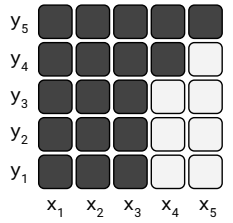

Where x1, x2, x3 are the source input

In [ ]:
### pseudo code for greedy search

# Tokenize the source sentence
src_tokens = tokenizer(source)
src_indices = [vocab.get_stoi()[t] for t in src_tokens]
src_tensor = torch.tensor(src_indices, device=device)

# Initialize the target sentence with the <bos> token
tgt_tensor = torch.tensor([vocab.get_stoi()['<bos>']], device=device)

inference_mask = rectangular_mask | upper_triangular_mask

# Translate the source sentence
for i in range(max_sentence_length):
    # Predict the next token
    y = model(torch.cat(src_tensor, tgt_tensor), mask = inference_mask)
    next_token = y.argmax(dim=-1)[:, -1]

    # Append the next token to the target sentence
    tgt_tensor = torch.cat([tgt_tensor, next_token])

    # Stop if the next token is the <eos> token
    if next_token == vocab.get_stoi()['<eos>']:
        break
